# ImageDataGenerator and transfer learning

Розглянемо ці речі безпосередньо на практиці

# Dogs vs. Cats

Тренувальний архів містить 25 000 зображень собак і котів.
- Навчіть свій алгоритм на цих файлах
- Передбачте мітки для test1.zip (1 = собака, 0 = кіт).


https://www.kaggle.com/c/dogs-vs-cats/data

# Завантажуємо дані

In [1]:
# Для CollabNotebook
! mkdir /root/.kaggle
! echo '{"username":"serhiikulikov","key":"14f4c0ccedf49d56e2d49f36398fd148"}' > /root/.kaggle/kaggle.json
! chmod 600 /root/.kaggle/kaggle.json

! pip install kaggle
! mkdir /root/kaggle
! kaggle competitions download -c dogs-vs-cats -p /content/kaggle/

 98% 793M/812M [00:03<00:00, 337MB/s]
100% 812M/812M [00:03<00:00, 271MB/s]


In [2]:
import os
import zipfile
# Подивимось що знаходиться у архіві
data_root = '/content/kaggle/dogs-vs-cats.zip'
data_r = zipfile.ZipFile(data_root, 'r')
data_r.printdir()

# Витягуємо дані
data_r.extractall(path = '/content/kaggle/')

File Name                                             Modified             Size
sampleSubmission.csv                           2019-12-11 04:17:58        88903
test1.zip                                      2019-12-11 04:18:02    284321224
train.zip                                      2019-12-11 04:18:34    569546721


In [3]:
import os
import shutil
import zipfile

def extract_images(archive_path, target_directory):
    with zipfile.ZipFile(archive_path, 'r') as zip_ref:
        zip_ref.extractall(target_directory)

def split_images(source_directory, target_train_directory, split, val_ratio, target_val_directory = None,):
    for filename in os.listdir(source_directory):
        if filename.startswith("cat"):
            category = "cats"
        elif filename.startswith("dog"):
            category = "dogs"
        else:
            continue

        if (split) and (hash(filename) % 100 < val_ratio * 100):
            shutil.move(os.path.join(source_directory, filename), os.path.join(target_val_directory, category))
        else:
            shutil.move(os.path.join(source_directory, filename), os.path.join(target_train_directory, category))

def main(archive_path, target_directory, dir_name, split, val_ratio):
    # Extract images from archive
    extract_images(archive_path, target_directory)

    # Define source and target directories
    if split:
      os.rename(target_directory+"/train", target_directory+"/tmp")
      source_directory = os.path.join(target_directory, "tmp")
      target_train_directory = os.path.join(target_directory, dir_name)
      target_val_directory = os.path.join(target_directory, 'validation')

      # Create target directories if they don't exist
      os.makedirs(target_train_directory, exist_ok=True)
      os.makedirs(target_val_directory, exist_ok=True)
      os.makedirs(os.path.join(target_train_directory, "cats"), exist_ok=True)
      os.makedirs(os.path.join(target_train_directory, "dogs"), exist_ok=True)
      os.makedirs(os.path.join(target_val_directory, "cats"), exist_ok=True)
      os.makedirs(os.path.join(target_val_directory, "dogs"), exist_ok=True)

      # Split images into train and test sets
      split_images(source_directory, target_train_directory, split, val_ratio, target_val_directory = target_val_directory)
      shutil.rmtree(source_directory)

    else:
      # Save test data
      os.rename(target_directory+"/test1", f'{target_directory}/{dir_name}')

In [4]:
# Cпліт для трейн даних
if __name__ == "__main__":
    archive_path = "/content/kaggle/train.zip"  # Шлях до архіву
    target_directory = "/content/data"  # Директорія для розархівування зображень
    dir_name = 'train'
    split = True
    val_ratio = 0.2  # Відсоток фотографій для тестування
    main(archive_path, target_directory, dir_name, split, val_ratio)

In [5]:
# Cпліт для тестових даних
if __name__ == "__main__":
    archive_path = "/content/kaggle/test1.zip"  # Шлях до архіву
    target_directory = "/content/data"  # Директорія для розархівування зображень
    dir_name = 'test'
    split = False
    val_ratio = None # Відсоток фотографій для тестування
    main(archive_path, target_directory, dir_name, split, val_ratio)

In [6]:
print('-'*20, 'Train data', '-'*20)
print(os.listdir('/content/data/train/cats')[:5])
print(os.listdir('/content/data/train/dogs')[:5])
print()
print('-'*20, 'Validation data', '-'*20)
print(os.listdir('/content/data/validation/cats')[:5])
print(os.listdir('/content/data/validation/dogs')[:5])
print()
print('-'*20, 'Test data', '-'*20)
print(os.listdir('/content/data/test')[:5])

-------------------- Train data --------------------
['cat.7930.jpg', 'cat.5163.jpg', 'cat.6096.jpg', 'cat.10253.jpg', 'cat.3191.jpg']
['dog.4181.jpg', 'dog.9388.jpg', 'dog.1520.jpg', 'dog.1188.jpg', 'dog.4718.jpg']

-------------------- Validation data --------------------
['cat.6123.jpg', 'cat.3559.jpg', 'cat.10652.jpg', 'cat.5220.jpg', 'cat.9852.jpg']
['dog.2066.jpg', 'dog.11880.jpg', 'dog.6670.jpg', 'dog.9568.jpg', 'dog.5996.jpg']

-------------------- Test data --------------------
['6608.jpg', '4304.jpg', '2642.jpg', '5714.jpg', '2207.jpg']


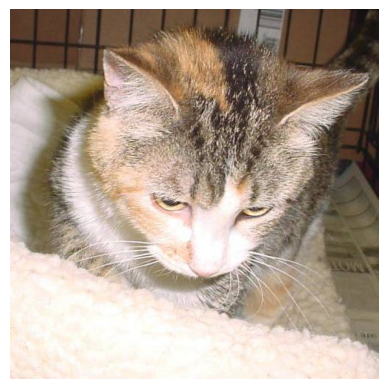

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Шлях до вашої фотографії
image_path_1 = '/content/data/train/dogs/dog.0.jpg'
image_path_2 = '/content/data/validation/cats/cat.708.jpg'
image_path_3 = '/content/data/test/9820.jpg'

# Завантаження та відображення фотографії
image = mpimg.imread(image_path_3)
plt.imshow(image)
plt.axis('off')  # Відключення відображення вісей координат
plt.show()

# Звичайний варіант побудови моделі

In [8]:
from keras import layers, models, optimizers


model_v1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu",input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),

    layers.Dense(1, activation="sigmoid")
])

model_v1.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    metrics=["accuracy"]
)
model_v1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

## Використання ImageDataGenerator

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [9]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [10]:
train_dir = '/content/data/train'
validation_dir = '/content/data/validation'

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

Found 19936 images belonging to 2 classes.
Found 5064 images belonging to 2 classes.


In [12]:
history_v1 = model_v1.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[early_stopping_callback]
)

Epoch 1/30
100/100 [==============================] - 13s 121ms/step - loss: 0.7818 - accuracy: 0.4755 - val_loss: 0.6915 - val_accuracy: 0.5800
Epoch 2/30
100/100 [==============================] - 13s 128ms/step - loss: 0.7012 - accuracy: 0.5060 - val_loss: 0.6898 - val_accuracy: 0.5370
Epoch 3/30
100/100 [==============================] - 12s 121ms/step - loss: 0.6683 - accuracy: 0.6015 - val_loss: 0.6355 - val_accuracy: 0.6510
Epoch 4/30
100/100 [==============================] - 12s 116ms/step - loss: 0.6295 - accuracy: 0.6570 - val_loss: 0.6500 - val_accuracy: 0.6380
Epoch 5/30
100/100 [==============================] - 12s 120ms/step - loss: 0.5972 - accuracy: 0.6725 - val_loss: 0.6126 - val_accuracy: 0.6530
Epoch 6/30
100/100 [==============================] - 12s 122ms/step - loss: 0.5857 - accuracy: 0.6799 - val_loss: 0.6595 - val_accuracy: 0.6470
Epoch 7/30
100/100 [==============================] - 12s 119ms/step - loss: 0.5583 - accuracy: 0.7115 - val_loss: 0.5588 - val_ac

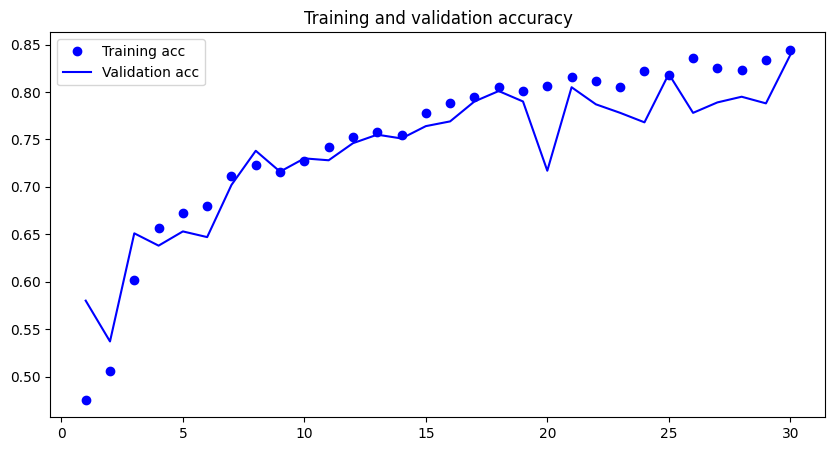

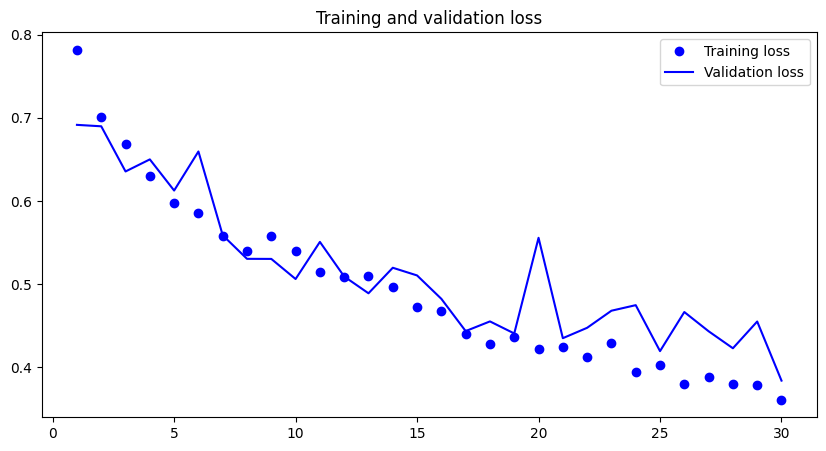

In [13]:
import matplotlib.pyplot as plt


acc = history_v1.history["accuracy"]
val_acc = history_v1.history["val_accuracy"]

loss = history_v1.history["loss"]
val_loss = history_v1.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,5))
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(10,5))

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

# Data Augmentation

![alt text](https://miro.medium.com/v2/resize:fit:1400/1*5_LOOgcnxzk1wfOTiMlwCg.png)

In [14]:
datagen = ImageDataGenerator(
    # featurewise_center = , # Логічний параметр. Якщо встановлено на True, то середнє значення кожного ознаки буде відніматися від кожного зображення по всьому набору даних.
    # samplewise_center = , # Логічний параметр. Якщо встановлено на True, то середнє значення кожного зображення буде відніматися від самого зображення
    # featurewise_std_normalization = , # Логічний параметр. Якщо встановлено на True, то вся ознака буде стандартизована на основі середнього значення та стандартного відхилення навчального набору даних.
    # samplewise_std_normalization = , # Логічний параметр. Якщо встановлено на True, то кожне зображення буде стандартизоване на основі свого середнього значення та стандартного відхилення.
    # zca_whitening = , # Логічний параметр. Якщо встановлено на True, то застосовується метод ZCA Whitening до зображень.
    # zca_epsilon = , # араметр, який використовується в методі ZCA Whitening для регулювання нормалізації.
    # rescale=1./255, # Коефіцієнт масштабування зображень (наприклад, 1.0/255 для нормалізації пікселів до значень від 0 до 1).
    rotation_range=40, # Діапазон обертання зображень (у градусах).
    width_shift_range=0.2, # Діапазон зсуву зображень по ширині
    height_shift_range=0.2,# Діапазон зсуву зображень по висоті.
    shear_range=0.2, # Діапазон зміщення (перекосу) зображень
    zoom_range=0.2, #  Діапазон масштабування зображень.
    horizontal_flip=True, # Логічне значення, що вказує, чи повинні бути випадково відзеркалені зображення по горизонталі.
    # vertical_flip = False # Логічне значення, що вказує, чи повинні бути випадково відзеркалені зображення по вертикалі.
    fill_mode="nearest", # Спосіб заповнення порожніх пікселів після виконання афінних трансформацій.
    # channel_shift_range= , #  Діапазон зміни значень каналів кольору. Наприклад, якщо ви встановите channel_shift_range = 20,
                             # то значення кожного пікселя в кожному кольоровому каналі може змінюватись на випадкову величину від -20 до +20.
                             # Це може призвести до тонких змін у кольорі та контрасті зображення, що допоможе моделі вивчати більш різноманітні функції.
    # validation_split = , Відсоток зображень, які мають бути збережені як валідаційний набір даних (застосовується тільки при використанні методу flow_from_directory).
)

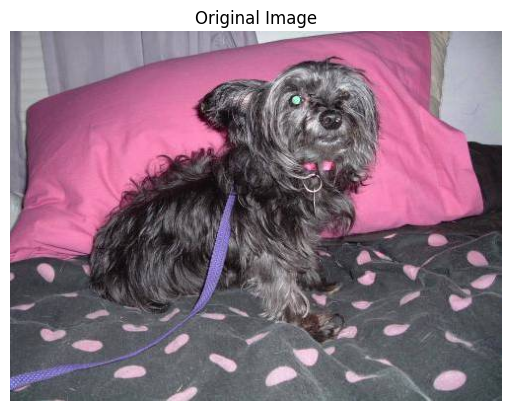

In [17]:
image_path = image_path_1
image = plt.imread(image_path)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

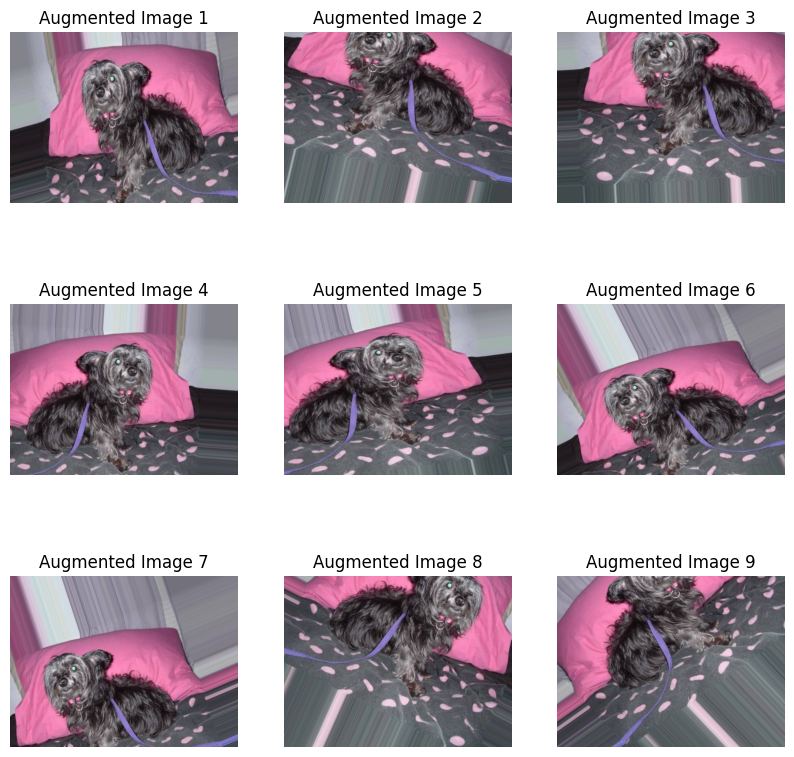

In [18]:
# Розширення зображення
image = image.reshape((1,) + image.shape)  # Розширюємо розмір для відповідності пакету даних

# Генерування пакету аугментованих зображень
augmented_images = datagen.flow(image, batch_size=1)
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = augmented_images.next()[0]
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image.astype('uint8'))
    plt.title(f'Augmented Image {i+1}')
    plt.axis('off')
plt.show()

https://fairyonice.github.io/Learn-about-ImageDataGenerator.html

## Модель з аугментацією

In [19]:
from keras import layers
from keras import models


model_v2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),

    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model_v2.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    metrics=["acc"]
)
model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

Found 19936 images belonging to 2 classes.
Found 5064 images belonging to 2 classes.


In [22]:
history_v2 = model_v2.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[early_stopping_callback]
)

Epoch 1/30


<ipython-input-22-bd56f17781c8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_v2 = model_v2.fit_generator(


50/50 [==============================] - 9s 187ms/step - loss: 0.6062 - acc: 0.6720 - val_loss: 0.5804 - val_acc: 0.6840
Epoch 2/30
50/50 [==============================] - 9s 188ms/step - loss: 0.6199 - acc: 0.6500 - val_loss: 0.5710 - val_acc: 0.7080
Epoch 3/30
50/50 [==============================] - 10s 190ms/step - loss: 0.6245 - acc: 0.6490 - val_loss: 0.6231 - val_acc: 0.6590
Epoch 4/30
50/50 [==============================] - 9s 188ms/step - loss: 0.6211 - acc: 0.6600 - val_loss: 0.5615 - val_acc: 0.7120
Epoch 5/30
50/50 [==============================] - 10s 191ms/step - loss: 0.6010 - acc: 0.6670 - val_loss: 0.5918 - val_acc: 0.6930
Epoch 6/30
50/50 [==============================] - 9s 187ms/step - loss: 0.6201 - acc: 0.6630 - val_loss: 0.5747 - val_acc: 0.6990
Epoch 7/30
50/50 [==============================] - 9s 187ms/step - loss: 0.5848 - acc: 0.7010 - val_loss: 0.5340 - val_acc: 0.7280
Epoch 8/30
50/50 [==============================] - 10s 191ms/step - loss: 0.5975 - a

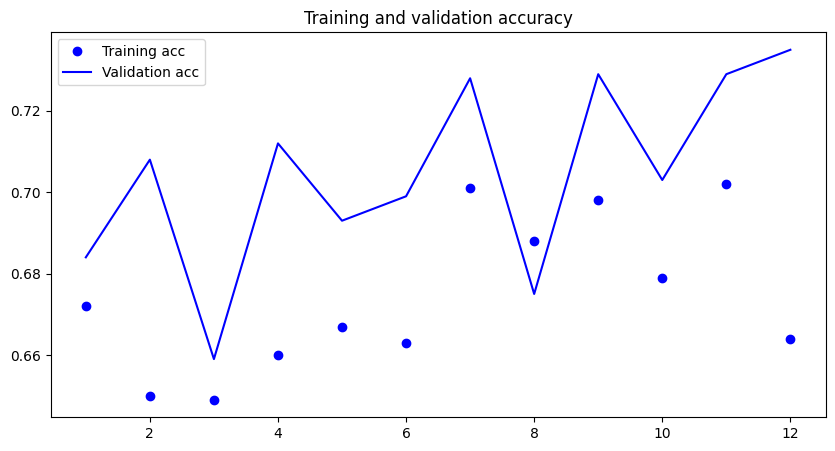

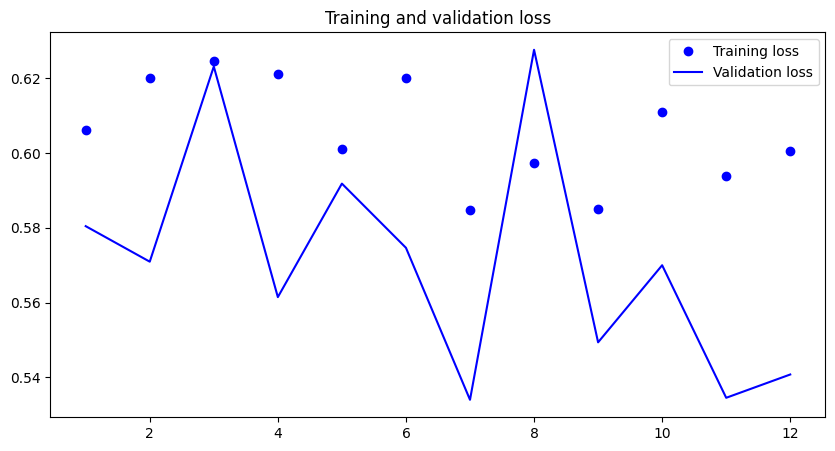

In [23]:
import matplotlib.pyplot as plt


acc = history_v2.history["acc"]
val_acc = history_v2.history["val_acc"]

loss = history_v2.history["loss"]
val_loss = history_v2.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,5))
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(10,5))

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

# Transfer learning

**Перенесення навчання (transfer learning)** - це метод в глибокому навчанні, який використовує знання, отримане від рішення однієї задачі, для поліпшення результатів у іншій задачі. У контексті нейронних мереж, це означає використання ваг (weights) та архітектури нейронної мережі, яка була навчена на великому обсязі даних, для вирішення подібної задачі.

Основні кроки перенесення навчання:

1. **Вибір попередньо навченої моделі**: Виберіть відповідну попередньо навчену модель, яка відповідає вашому набору даних та задачі.

2. **Замороження базової моделі**: Замороження ваг базової моделі означає, що вони залишаються незмінними під час тренування моделі на нових даних.

3. **Додавання нових шарів**: Додайте додаткові шари, які вирішують вашу конкретну задачу, поверх базової моделі.

4. **Тренування:** Тренуйте модель на нових даних, використовуючи методи навчання глибоких нейронних мереж.

5. **Настройка (Fine-tuning) (опційно)**: Якщо у вас є достатньо багато даних, можна розморозити деякі верхні шари базової моделі і тренувати їх разом з доданими шарами. Це допоможе адаптувати базову модель до вашої конкретної задачі.

![alt text](https://www.researchgate.net/publication/338540456/figure/fig1/AS:850909840015360@1579884123355/Transfer-learning-Transfer-learning-is-process-of-taking-pretrained-model-usually.png)

# Gradient Vanishing та Залишкові нейронні мережі (Residual Neural Network)

**Проблема зникнення градієнта** — це явище, яке виникає під час навчання глибоких нейронних мереж, коли градієнти, які використовуються для оновлення мережі, стають надзвичайно малими або «зникають», оскільки вони повертаються з вихідних шарів на попередні шари.

Під час процесу навчання нейронної мережі метою є мінімізація функції втрат шляхом регулювання вагових коефіцієнтів мережі

Наслідки проблеми зі зникаючим градієнтом включають повільну конвергенцію, застрягання мережі в низьких мінімумах і порушення вивчення глибоких представлень.

![alt text](https://assets-global.website-files.com/5ef788f07804fb7d78a4127a/61caee4adda606e789e8158a_vanishing%20gradient%20problem-min.png)

ResNet


![alt text](https://miro.medium.com/v2/resize:fit:1400/0*9LqUp7XyEx1QNc6A.png)

https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50

In [24]:
from tensorflow.keras.applications import ResNet50

# Завантаження моделі ResNet50 без верхніх повнозв'язних шарів
res_net_model = ResNet50(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3)
                 )

# Виведення опису моделі
res_net_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                      

Проект **ImageNet** — це велика візуальна база даних, розроблена для використання в дослідженні програмного забезпечення візуального розпізнавання об’єктів. Понад 14 мільйонів зображень були вручну анотовані в рамках проекту, щоб вказати, які об’єкти зображені, і принаймні в одному мільйоні зображень також передбачені обмежувальні рамки. ImageNet містить понад 20 000 категорій , типова категорія, така як «повітряна куля» або «полуниця», складається з кількох сотень зображень.
https://en.wikipedia.org/wiki/ImageNet
![alt text](https://production-media.paperswithcode.com/datasets/ImageNet-0000000008-f2e87edd_Y0fT5zg.jpg)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import RMSprop

res_net_model.trainable = False

model_v3 = Sequential([
    res_net_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid'),
])
model_v3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               6553728   
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 30141569 (114.98 MB)
Trainable params: 6553857 (25.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [26]:
from keras import optimizers
model_v3.compile(
    loss="binary_crossentropy",
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    metrics=["accuracy"]
)

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

Found 19936 images belonging to 2 classes.
Found 5064 images belonging to 2 classes.


In [28]:
history_v3 = model_v3.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[early_stopping_callback]
)

Epoch 1/30
50/50 [==============================] - 18s 309ms/step - loss: 1.5414 - accuracy: 0.5220 - val_loss: 0.6858 - val_accuracy: 0.5700
Epoch 2/30
50/50 [==============================] - 14s 284ms/step - loss: 0.8120 - accuracy: 0.5230 - val_loss: 0.8810 - val_accuracy: 0.5100
Epoch 3/30
50/50 [==============================] - 14s 277ms/step - loss: 0.8162 - accuracy: 0.5300 - val_loss: 0.6442 - val_accuracy: 0.6320
Epoch 4/30
50/50 [==============================] - 14s 277ms/step - loss: 0.8237 - accuracy: 0.5350 - val_loss: 0.8456 - val_accuracy: 0.5080
Epoch 5/30
50/50 [==============================] - 14s 279ms/step - loss: 0.7710 - accuracy: 0.5610 - val_loss: 0.6349 - val_accuracy: 0.6500
Epoch 6/30
50/50 [==============================] - 14s 273ms/step - loss: 0.8617 - accuracy: 0.5370 - val_loss: 1.1602 - val_accuracy: 0.4960
Epoch 7/30
50/50 [==============================] - 14s 275ms/step - loss: 0.7893 - accuracy: 0.5540 - val_loss: 0.9383 - val_accuracy: 0.5000

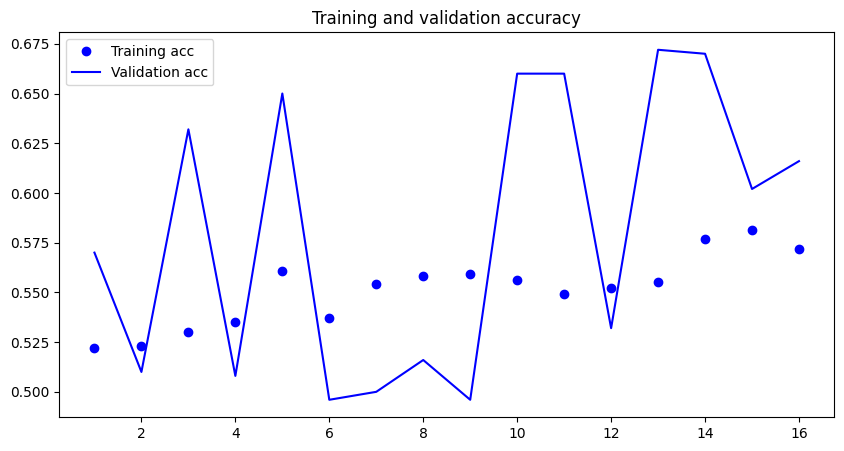

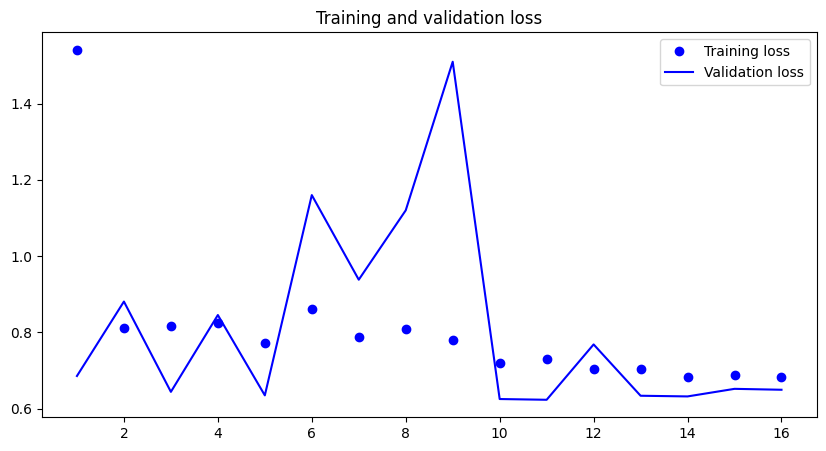

In [29]:
import matplotlib.pyplot as plt


acc = history_v3.history["accuracy"]
val_acc = history_v3.history["val_accuracy"]

loss = history_v3.history["loss"]
val_loss = history_v3.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,5))
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(10,5))

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

# VGG16

VGG16 відноситься до моделі VGG, яка також називається VGGNet. Це модель згорткової нейронної мережі (CNN), яка підтримує 16 рівнів.

К. Симонян і А. Зіссерман з Оксфордського університету запропонували цю модель і опублікували її в статті під назвою «Дуже глибокі згорткові мережі для розпізнавання великомасштабних зображень».

Understanding VGG16: Concepts, Architecture, and Performance https://datagen.tech/guides/computer-vision/vgg16/

Very Deep Convolutional Networks for Large-Scale Image Recognition. - https://arxiv.org/abs/1409.1556

![alt text](https://datagen.tech/wp-content/uploads/2022/11/image2-1.png)

In [30]:
import tensorflow as tf

from keras.applications.vgg16 import VGG16
from keras import models
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = False

model_v4 = models.Sequential([
   vgg16,
   layers.Flatten(),
   layers.Dense(128, activation="relu"),
   layers.Dense(1, activation="sigmoid"),
])

model_v4.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["acc"]
)

58889256/58889256 [==============================] - 0s 0us/step


In [31]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary"
)

Found 19936 images belonging to 2 classes.
Found 5064 images belonging to 2 classes.


In [32]:
history_v4 = model_v4.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[early_stopping_callback]
)

Epoch 1/30
50/50 [==============================] - 16s 299ms/step - loss: 0.6516 - acc: 0.6210 - val_loss: 0.5399 - val_acc: 0.7740
Epoch 2/30
50/50 [==============================] - 15s 298ms/step - loss: 0.5420 - acc: 0.7660 - val_loss: 0.4683 - val_acc: 0.7940
Epoch 3/30
50/50 [==============================] - 15s 295ms/step - loss: 0.4881 - acc: 0.7930 - val_loss: 0.4341 - val_acc: 0.8180
Epoch 4/30
50/50 [==============================] - 15s 296ms/step - loss: 0.4587 - acc: 0.8002 - val_loss: 0.3958 - val_acc: 0.8300
Epoch 5/30
50/50 [==============================] - 15s 296ms/step - loss: 0.4207 - acc: 0.8223 - val_loss: 0.3828 - val_acc: 0.8380
Epoch 6/30
50/50 [==============================] - 15s 297ms/step - loss: 0.3874 - acc: 0.8444 - val_loss: 0.3820 - val_acc: 0.8300
Epoch 7/30
50/50 [==============================] - 15s 294ms/step - loss: 0.3873 - acc: 0.8260 - val_loss: 0.3397 - val_acc: 0.8500
Epoch 8/30
50/50 [==============================] - 15s 293ms/step - 

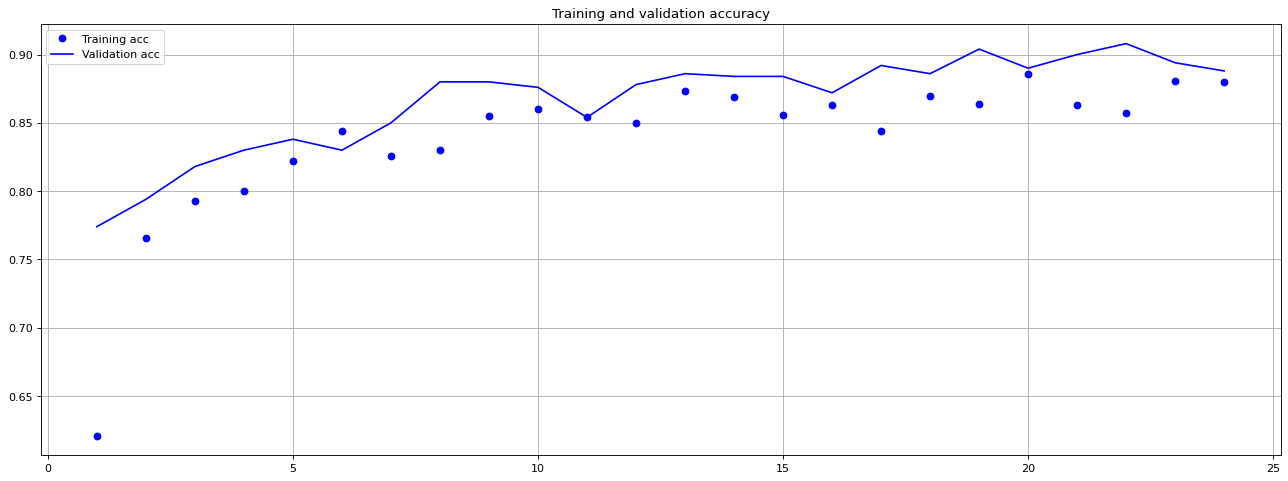

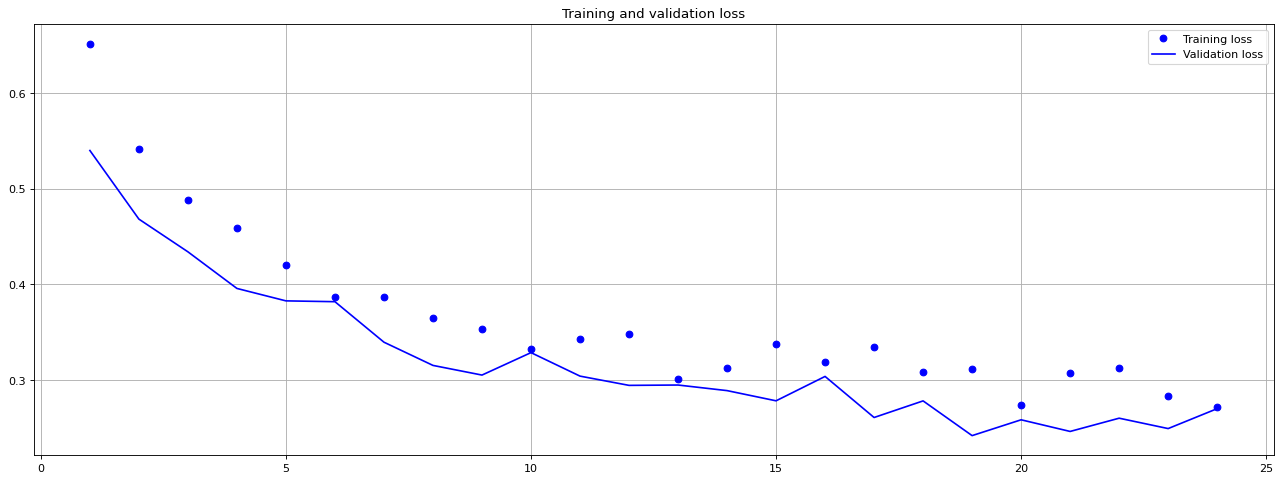

In [33]:
import matplotlib.pyplot as plt

acc = history_v4.history["acc"]
val_acc = history_v4.history["val_acc"]

loss = history_v4.history["loss"]
val_loss = history_v4.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

## Донавчання

In [34]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [35]:
vgg16.trainable = True
set_trainable = False
for layer in vgg16.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Задамося питанням чому б не донавчити більше шарів і чи не можна донавчити всю основу згортання цілком? Так вчинити можна, але треба мати на увазі такі факти:

1. Початкові шари згорткової основі кодують більш узагальнені ознаки, придатні для повторного використання, а вищі шари кодують конкретніші ознаки. Набагато корисніше доналаштувати конкретніші ознаки, тому що саме їх часто потрібно перепрофілювати для вирішення нового завдання. Цінність донавчання початкових шарів швидко падає в міру наближення до входу нейромережі.
2. Чим більше параметрів навчається, тим вищий ризик перенавчання. Згорткова основа має 15 мільйонів параметрів, тому було б занадто ризиковано намагатися донавчити її на невеликому наборі даних.
Тому в нашій ситуації найкращою стратегією буде донавчити лише кілька верхніх шарів згорткової основи. Зберемо все докупи:

In [36]:
model_v4a = models.Sequential([
   vgg16,
   layers.Flatten(),
   layers.Dense(256, activation="relu"),
   layers.Dense(1, activation="sigmoid"),
])

In [37]:
model_v4a.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
    metrics=["acc"]
)

history_v4a = model_v4a.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[early_stopping_callback]
)

Epoch 1/30
50/50 [==============================] - 20s 382ms/step - loss: 0.5355 - acc: 0.7430 - val_loss: 0.4244 - val_acc: 0.8160
Epoch 2/30
50/50 [==============================] - 19s 385ms/step - loss: 0.3927 - acc: 0.8370 - val_loss: 0.3032 - val_acc: 0.9020
Epoch 3/30
50/50 [==============================] - 19s 386ms/step - loss: 0.3559 - acc: 0.8430 - val_loss: 0.3281 - val_acc: 0.8280
Epoch 4/30
50/50 [==============================] - 20s 393ms/step - loss: 0.2924 - acc: 0.8800 - val_loss: 0.2850 - val_acc: 0.8800
Epoch 5/30
50/50 [==============================] - 19s 384ms/step - loss: 0.2739 - acc: 0.8830 - val_loss: 0.2295 - val_acc: 0.8820
Epoch 6/30
50/50 [==============================] - 19s 385ms/step - loss: 0.2524 - acc: 0.8996 - val_loss: 0.2329 - val_acc: 0.9020
Epoch 7/30
50/50 [==============================] - 20s 390ms/step - loss: 0.2427 - acc: 0.8920 - val_loss: 0.2365 - val_acc: 0.8980
Epoch 8/30
50/50 [==============================] - 19s 389ms/step - 

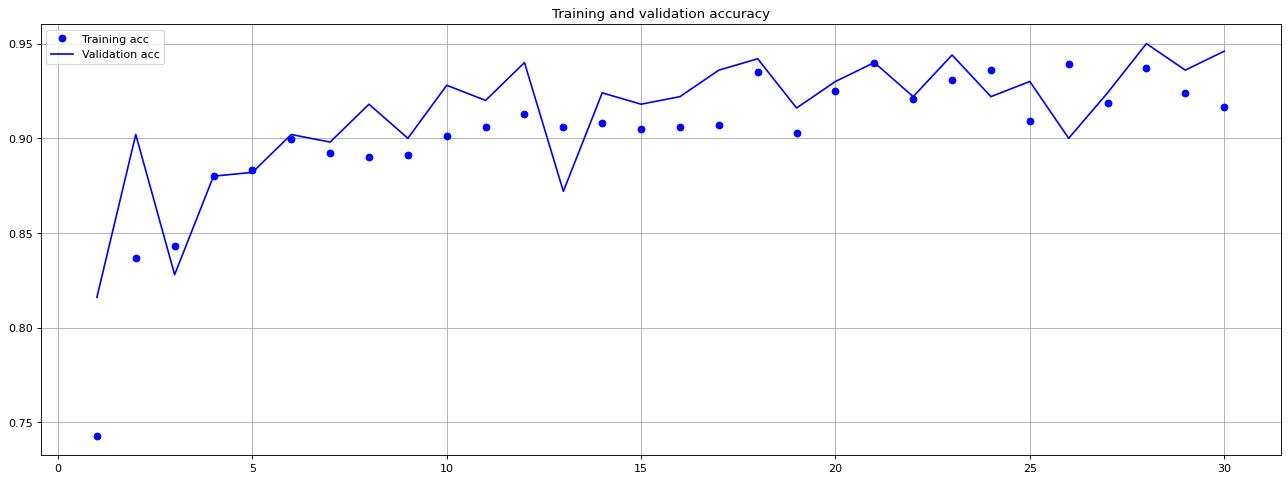

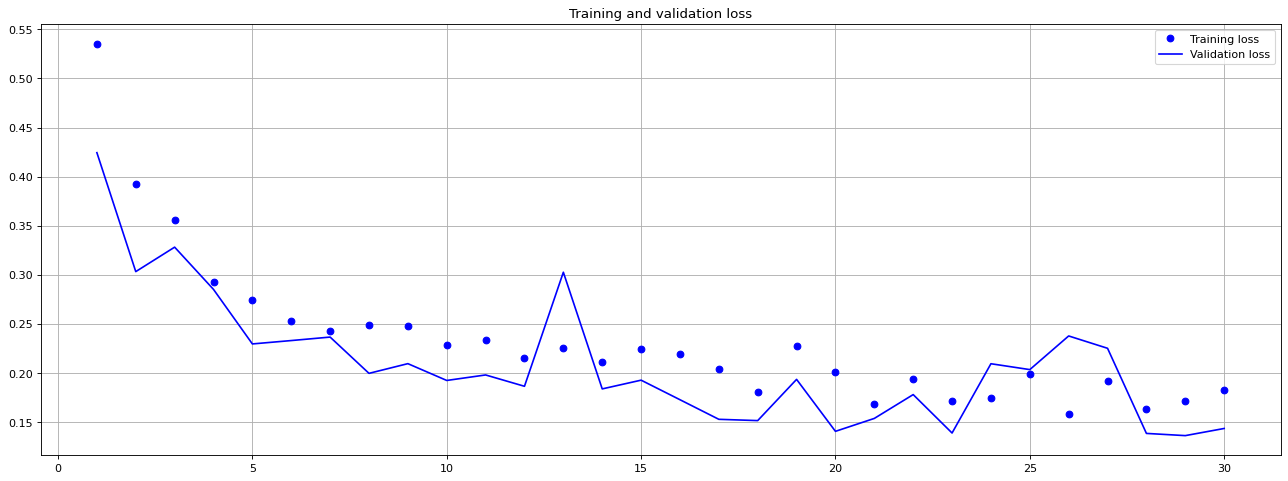

In [38]:
import matplotlib.pyplot as plt

acc = history_v4a.history["acc"]
val_acc = history_v4a.history["val_acc"]

loss = history_v4a.history["loss"]
val_loss = history_v4a.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

# MobileNet

![alt text](https://media.licdn.com/dms/image/D5612AQHx0YflBhTXZA/article-cover_image-shrink_720_1280/0/1687079504838?e=2147483647&v=beta&t=Kn5JGhWk2gWwU7bAH9ov3i-R99WrisMpjdtoe0uyMKk)

https://medium.com/@godeep48/an-overview-on-mobilenet-an-efficient-mobile-vision-cnn-f301141db94d

In [39]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

MNv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
MNv2.trainable = False

model_v5 = Sequential([
    MNv2,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_v5.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_v5.summary()

9406464/9406464 [==============================] - 0s 0us/step


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_5 (Flatten)         (None, 32000)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               4096128   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 6354241 (24.24 MB)
Trainable params: 4096257 (15.63 MB)
Non-trainable params: 2257984 (8.61 MB)
__________

In [40]:
history_v5 = model_v5.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[early_stopping_callback]
)

Epoch 1/30
50/50 [==============================] - 12s 189ms/step - loss: 1.7548 - accuracy: 0.8830 - val_loss: 1.1881 - val_accuracy: 0.9200
Epoch 2/30
50/50 [==============================] - 8s 168ms/step - loss: 0.9858 - accuracy: 0.9010 - val_loss: 0.2705 - val_accuracy: 0.8960
Epoch 3/30
50/50 [==============================] - 9s 170ms/step - loss: 0.2731 - accuracy: 0.9100 - val_loss: 0.1471 - val_accuracy: 0.9380
Epoch 4/30
50/50 [==============================] - 8s 169ms/step - loss: 0.2120 - accuracy: 0.9036 - val_loss: 0.1024 - val_accuracy: 0.9500
Epoch 5/30
50/50 [==============================] - 8s 165ms/step - loss: 0.2107 - accuracy: 0.9020 - val_loss: 0.1376 - val_accuracy: 0.9520
Epoch 6/30
50/50 [==============================] - 8s 166ms/step - loss: 0.2549 - accuracy: 0.9100 - val_loss: 0.0974 - val_accuracy: 0.9540
Epoch 7/30
50/50 [==============================] - 8s 169ms/step - loss: 0.2074 - accuracy: 0.9180 - val_loss: 0.1064 - val_accuracy: 0.9520
Epoch

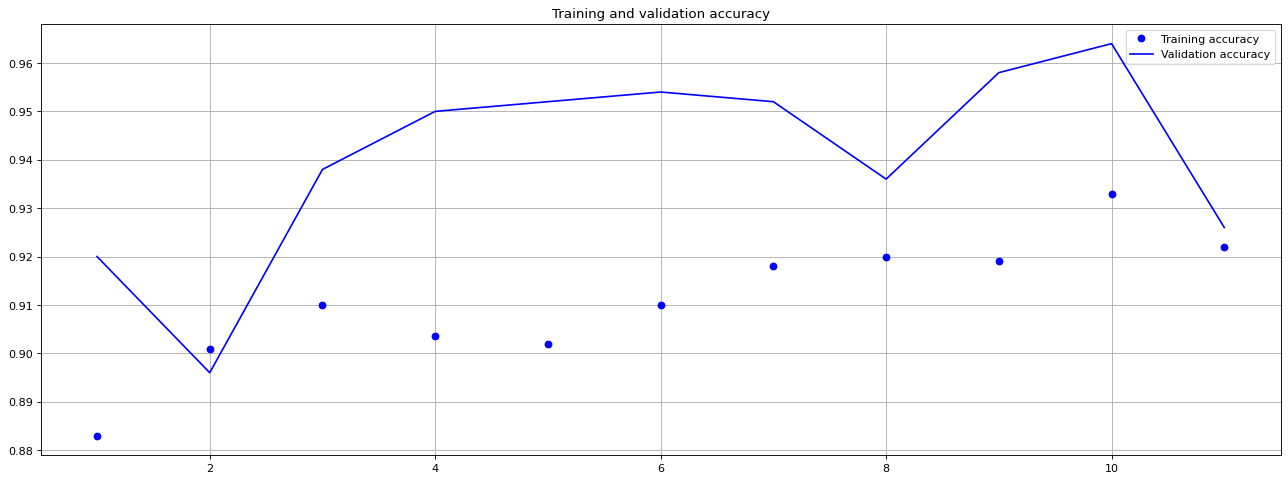

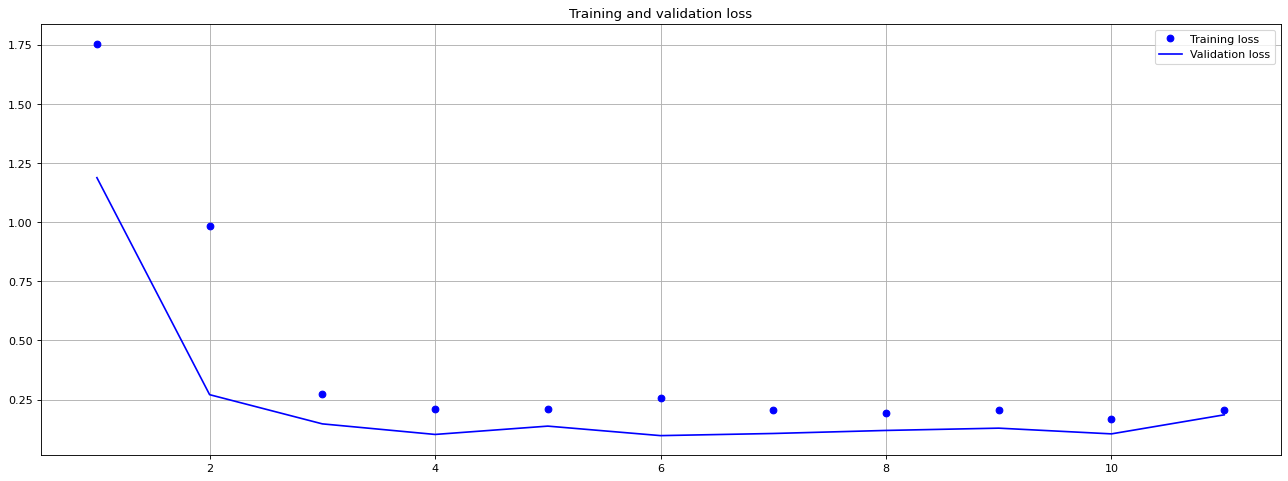

In [41]:
import matplotlib.pyplot as plt

acc = history_v5.history["accuracy"]
val_acc = history_v5.history["val_accuracy"]

loss = history_v5.history["loss"]
val_loss = history_v5.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

1. https://www.tensorflow.org/guide/keras/transfer_learning
2. https://medium.com/@fakhar3534/unfreezing-and-transfer-learning-in-deep-learning-a31ef2ad9e8c
3. https://medium.com/@elvenkim1/difference-between-transfer-learning-vs-fine-tuning-3e5d480501be